In [4]:
# Step 1: Install dependencies
!pip install -q transformers datasets tensorflow

In [24]:
# Step 2: Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, create_optimizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow_datasets as tfds
import random

In [3]:
# Step 3: Load IMDB dataset
raw = tfds.load('imdb_reviews', split=['train', 'test'], as_supervised=True)
train_raw, test_raw = raw

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HZJV3H_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HZJV3H_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HZJV3H_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [6]:
# Step 4: Take smaller, high-quality samples (2000 train, 500 val, 500 test)
train_raw = train_raw.shuffle(25000, seed=42)
val_raw = train_raw.skip(2000).take(500)
train_raw = train_raw.take(2000)
test_raw = test_raw.shuffle(25000, seed=42).take(500)

In [8]:
# Step 5: Preprocess (Text and Labels)
def to_numpy(dataset):
    texts, labels = [], []
    for text, label in dataset:
        texts.append(text.numpy().decode('utf-8'))
        labels.append(int(label.numpy()))
    return texts, labels

train_texts, train_labels = to_numpy(train_raw)
val_texts, val_labels = to_numpy(val_raw)
test_texts, test_labels = to_numpy(test_raw)

In [9]:
# Step 6: Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=256, return_tensors="tf")

train_enc = tokenize(train_texts)
val_enc = tokenize(val_texts)
test_enc = tokenize(test_texts)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [12]:
# Step 7: Build TensorFlow Datasets
def build_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((dict(encodings), labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_ds = build_dataset(train_enc, train_labels)
val_ds = build_dataset(val_enc, val_labels)
test_ds = build_dataset(test_enc, test_labels)

In [13]:
# Step 8: Load model and optimizer
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
# Learning rate & optimizer setup
num_train_steps = len(train_ds) * 3
opt, _ = create_optimizer(init_lr=3e-5, num_warmup_steps=0, num_train_steps=num_train_steps)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [14]:
# ✅ Step 9: Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
63/63 [==============================] - 3090s 49s/step - loss: 0.4773 - accuracy: 0.7750 - val_loss: 0.2879 - val_accuracy: 0.8680
Epoch 2/3
63/63 [==============================] - 3066s 49s/step - loss: 0.2317 - accuracy: 0.9155 - val_loss: 0.2914 - val_accuracy: 0.8920
Epoch 3/3
63/63 [==============================] - 3067s 49s/step - loss: 0.1345 - accuracy: 0.9590 - val_loss: 0.2281 - val_accuracy: 0.9120


In [15]:
# Step 10: Evaluate on test data
logits = model.predict(test_ds).logits
preds = tf.argmax(logits, axis=1).numpy()
acc = accuracy_score(test_labels, preds)

print(f"\nTest Accuracy: {acc * 100:.2f}%")
print("\nClassification Report:\n", classification_report(test_labels, preds))

16/16 [==============================] - 237s 15s/step

Test Accuracy: 88.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       243
           1       0.90      0.86      0.88       257

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



In [20]:
# Step 11: Save Predictions to CSV

# Compute predicted probabilities using softmax
predicted_probs = tf.nn.softmax(logits, axis=1).numpy()
predicted_classes = preds  # from Step 10

df_preds = pd.DataFrame({
    "Actual": ["Positive" if y == 1 else "Negative" for y in test_labels],
    "Predicted": ["Positive" if y == 1 else "Negative" for y in predicted_classes],
    "Predicted_prob": [round(max(p)*100, 2) for p in predicted_probs]
})
df_preds.to_csv("DistilBERT_Predictions.csv", index=False)
print("Predictions saved to CSV.")

Predictions saved to CSV.


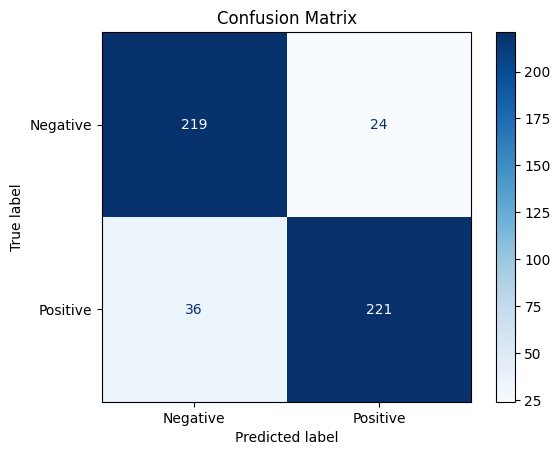

In [25]:
# Step 12: Confusion Matrix
cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

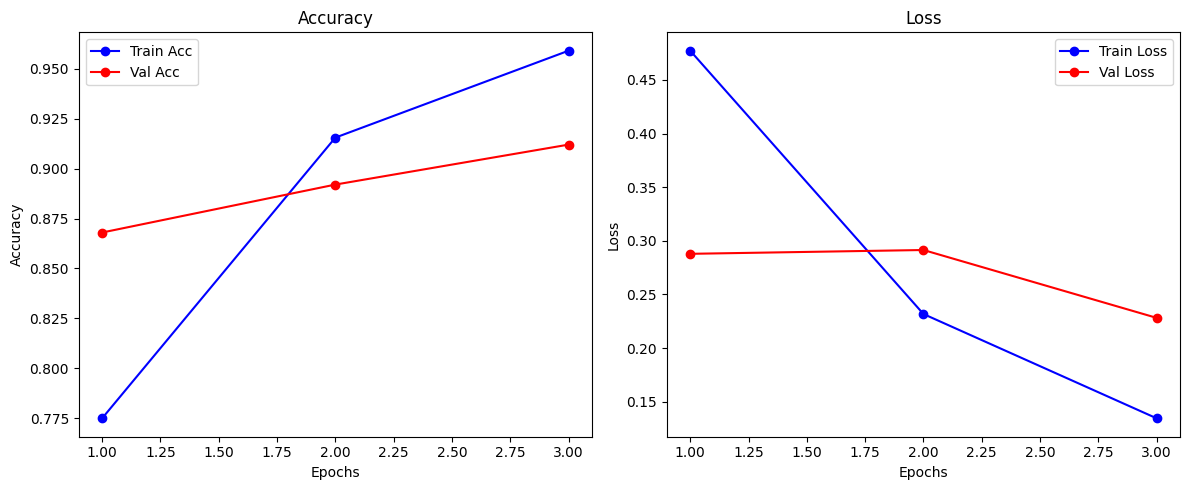

In [26]:
# Step 13: Plot Accuracy and Loss
epochs = range(1, len(history.history["accuracy"]) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], 'bo-', label="Train Acc")
plt.plot(epochs, history.history["val_accuracy"], 'ro-', label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], 'bo-', label="Train Loss")
plt.plot(epochs, history.history["val_loss"], 'ro-', label="Val Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Step 14: Save and Zip Model
model.save_pretrained("sentiment_model")
tokenizer.save_pretrained("sentiment_model")

# Zip the model directory
!zip -r sentiment_model.zip sentiment_model > /dev/null

# Download the zipped model
from google.colab import files
files.download("sentiment_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# Step 15: User Input Prediction
def predict_user_input():
    text = input("Enter a movie review: ")
    inputs = tokenizer([text], return_tensors="tf", truncation=True, padding="max_length", max_length=256)
    output = model(inputs).logits
    prob = tf.nn.softmax(output, axis=1).numpy()[0]
    pred = np.argmax(prob)
    print(f"\nPredicted Sentiment: {'Positive' if pred == 1 else 'Negative'} (Confidence: {prob[pred]*100:.2f}%)")

predict_user_input()

Enter a movie review: Great time. Loved it!

Predicted Sentiment: Positive (Confidence: 95.37%)


In [ ]:
# Step 16: Download Predictions CSV
files.download("DistilBERT_Predictions.csv")